In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
from pinns import *
from local_utils import *

import pandas as pd

from intro import *

######################################################
1 outputs_second_search/solution_10_0_26.npy


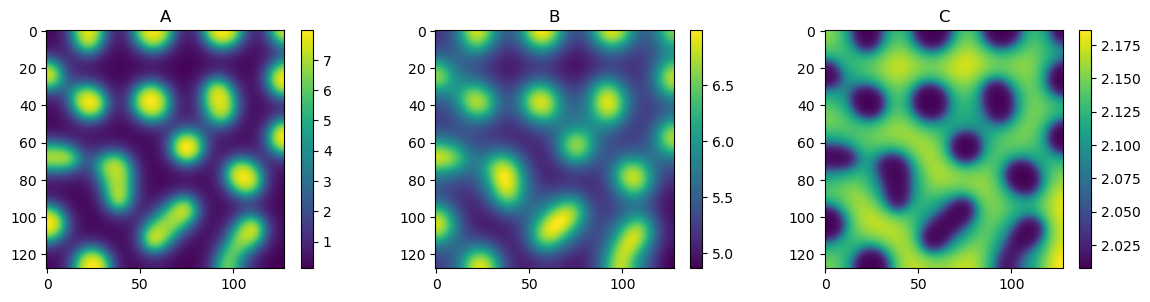

In [2]:
print("######################################################")
index = 1
path = subnet_df["path"].iloc[index]
print(index, path)
(params, res, k_max) = load_dataset(path)

plot_n_im([to(res[-1, 0, :]), to(res[-1, 1, :]), to(res[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
    
T=1    
L=1
mesh_steps=128
data = reshape(res, T)

In [154]:
def act(x, km, n=2):
    return x**n / (x**n + km**n)

def inh(x, km, n=2):
    return km**n / (km**n + x**n)

def create_Circuit_3954_L2(A, B, C, e = lambda x: x, L=10):
    delta_steps = A.shape[0]*A.shape[1]/(L**2) 
    laplacian_A = delta_steps*grad_diff(A)[1:-1, 1:-1].flatten()[np.newaxis,...]
    laplacian_B = delta_steps*grad_diff(B)[1:-1, 1:-1].flatten()[np.newaxis,...]
    A = A[1:-1, 1:-1].flatten()[np.newaxis,...]
    B = B[1:-1, 1:-1].flatten()[np.newaxis,...]
    C = C[1:-1, 1:-1].flatten()[np.newaxis,...]
    def Circuit_3954_L2(D_A, D_B, n, 
                        b_A, mu_A, V_A, K_AA, K_AB, K_AC,
                        b_B, mu_B, V_B, K_BA, K_BC,
                        b_C, mu_C, V_C, K_CB, K_CC):
        F_A =  e(b_A) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n) - e(mu_A) * A    
        F_B =  e(b_B) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n) - e(mu_B) * B        
        F_C =  e(b_C) + e(V_C)*inh(A, e(K_AC), n)*inh(B, e(K_BC), n)*act(C, e(K_CC), n) - mu_C * C
        
        
        loss_A = np.mean((D_A * laplacian_A + F_A)**2, axis=1)
        loss_B = np.mean((D_B * laplacian_B + F_B)**2, axis=1)
        loss_C = np.mean(F_C**2, axis=1)
        
        return loss_A + loss_B + loss_C
    return Circuit_3954_L2

def create_Circuit_3954_L2_scalar_params(A, B, C, D_A, D_B, n, L=10):
    delta_steps = A.shape[0]*A.shape[1]/(L**2) 
    laplacian_A = D_A*delta_steps*grad_diff(A)[1:-1, 1:-1]
    laplacian_B = D_B*delta_steps*grad_diff(B)[1:-1, 1:-1]
    A = A[1:-1, 1:-1]
    B = B[1:-1, 1:-1]
    C = C[1:-1, 1:-1]
    def Circuit_3954_L2(b_A, mu_A, V_A, K_AA, K_AB, K_AC,
                        b_B, mu_B, V_B, K_BA, K_BC,
                        b_C, mu_C, V_C, K_CB, K_CC):
        F_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A    
        F_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B        
        F_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
        
        
        loss_A = np.mean((laplacian_A + F_A)**2)
        loss_B = np.mean((laplacian_B + F_B)**2)
        loss_C = np.mean(F_C**2)
        
        return loss_A + loss_B + loss_C
    return Circuit_3954_L2

A = data[0,..., -1]
B = data[1,..., -1]
C = data[2,..., -1]
Circuit_3954_L2 = create_Circuit_3954_L2(A, B, C)


In [155]:
Circuit_3954_L2(np.array([D_A]), np.array([D_B]), np.array([n]),
np.array([b_A]), np.array([mu_A]), np.array([V_A]), np.array([K_AA]), np.array([K_AB]), np.array([K_AC]),
np.array([b_B]), np.array([mu_B]), np.array([V_B]), np.array([K_BA]), np.array([K_BC]),
np.array([b_C]), np.array([mu_C]), np.array([V_C]), np.array([K_CB]), np.array([K_CC]))

array([0.00178891])

In [350]:
(D_A, D_B,n, 
b_A, mu_A, V_A, K_AA, K_AB, K_AC,
b_B, mu_B, V_B, K_BA, K_BC,
b_C, mu_C, V_C, K_CB, K_CC) = tuple(params.values())

Circuit_3954_L2_sc = create_Circuit_3954_L2_scalar_params(A, B, C, D_A, D_B, n)

In [158]:
Circuit_3954_L2_sc(b_A, mu_A, V_A, K_AA, K_AB, K_AC,
                   b_B, mu_B, V_B, K_BA, K_BC,
                   b_C, mu_C, V_C, K_CB, K_CC)

0.0017889094796731994

In [133]:
# param_samples = np.random.multivariate_normal((D_A, D_B,n, 
#                                                b_A, mu_A, V_A, K_AA, K_AB, K_AC,
#                                                b_B, mu_B, V_B, K_BA, K_BC,
#                                                b_C, mu_C, V_C, K_CB, K_CC), 
#                                                np.eye(19), (100000,1))
# (D_As, D_Bs, ns, 
# b_As, mu_As, V_As, K_AAs, K_ABs, K_ACs,
# b_Bs, mu_Bs, V_Bs, K_BAs, K_BCs,
# b_Cs, mu_Cs, V_Cs, K_CBs, K_CCs) = tuple([param_samples[..., i] for i in range(param_samples.shape[-1])])
# L2_samples = Circuit_3954_L2(D_As, D_Bs, ns, 
#                              b_As, mu_As, V_As, K_AAs, K_ABs, K_ACs,
#                              b_Bs, mu_Bs, V_Bs, K_BAs, K_BCs,
#                              b_Cs, mu_Cs, V_Cs, K_CBs, K_CCs)

In [352]:
(D_A, D_B,n, 
b_A, mu_A, V_A, K_AA, K_AB, K_AC,
b_B, mu_B, V_B, K_BA, K_BC,
b_C, mu_C, V_C, K_CB, K_CC) = tuple(params.values())

original_params = np.array([b_A, mu_A, V_A, K_AA, K_AB, K_AC,
                                  b_B, mu_B, V_B, K_BA, K_BC,
                                  b_C, mu_C, V_C, K_CB, K_CC])

current_point = np.random.normal(original_params, scale=original_params*1)
current_point[current_point <= 0] = 1e-5

max_steps = 1000000
L2_samples = np.zeros(max_steps)
point_samples = np.zeros((max_steps,current_point.shape[0]))
L2_samples[0] = Circuit_3954_L2_sc(*current_point)
point_samples[0, :] = current_point 
for step in range(1, max_steps):
    next_point = np.random.normal(original_params, scale=original_params*.1)
    next_point[next_point <= 0] = 1e-5
    next_L2_sample = Circuit_3954_L2_sc(*next_point)
    if min(1, L2_samples[step-1]/next_L2_sample) > np.random.rand():
        current_point = next_point
        L2_samples[step] = next_L2_sample
    else:
        L2_samples[step] = L2_samples[step-1]
    point_samples[step, :] = current_point     
    

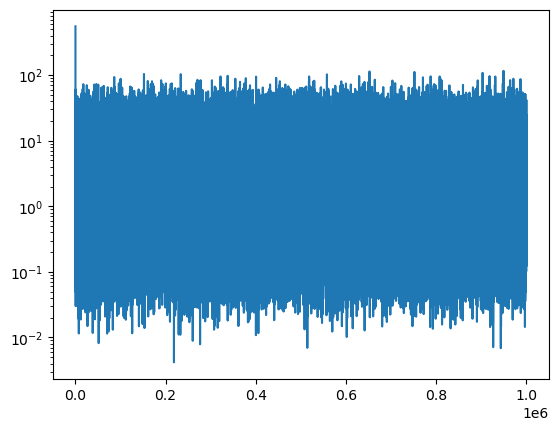

In [353]:
plt.plot(L2_samples);plt.yscale('log')

In [208]:
point_samples.shape

(10000, 16)

In [437]:
from sklearn.decomposition import PCA
pca = PCA()
#principalComponents = pca.fit(point_samples/np.std(point_samples, axis=0))
principalComponents = pca.fit(point_samples)

In [435]:
pca.explained_variance_ratio_

array([0.1098662 , 0.07684318, 0.06927892, 0.06906499, 0.06550864,
       0.06381806, 0.06341648, 0.06310332, 0.06304336, 0.06238865,
       0.06196037, 0.06046724, 0.05788798, 0.05656409, 0.04364051,
       0.01314799])

In [438]:
pca.explained_variance_ratio_

array([9.40660374e-01, 2.54347933e-02, 9.48549661e-03, 7.51455479e-03,
       2.55305712e-03, 2.39533524e-03, 2.35731866e-03, 2.33952416e-03,
       2.30198575e-03, 2.08806762e-03, 1.47771756e-03, 1.28062510e-03,
       9.21681606e-05, 1.80440826e-05, 9.37727409e-07, 9.48320431e-11])

In [ ]:
'b_A': 0.001, 'mu_A': 0.1, 'V_A': 5.0, 'K_AA': 5.0, 
'K_AB': 5.0, 'K_AC': 5.0, 'b_B': 1.0, 'mu_B': 0.5, 
'V_B': 10.0, 'K_BA': 5.0, 'K_BC': 5.0, 'b_C': 20.0, 
'mu_C': 10.0, 'V_C': 100.0, 'K_CB': 10.0, 'K_CC': 5.0

In [211]:
principalComponents.shape

(10000, 16)

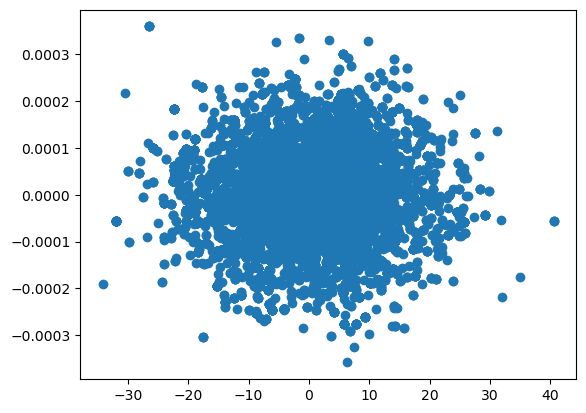

In [220]:
plt.scatter(principalComponents[:, 0], principalComponents[:, -1])

In [356]:
def directional_linspace(origin, direction, steps):
    return origin[np.newaxis, ...] + steps[...,np.newaxis]*direction[np.newaxis, ...]

In [357]:
steps = np.linspace(-1, 1, 200)
test_points = directional_linspace(original_params, pca.components_[0], steps)
test_points2 = directional_linspace(original_params, pca.components_[-1], steps)

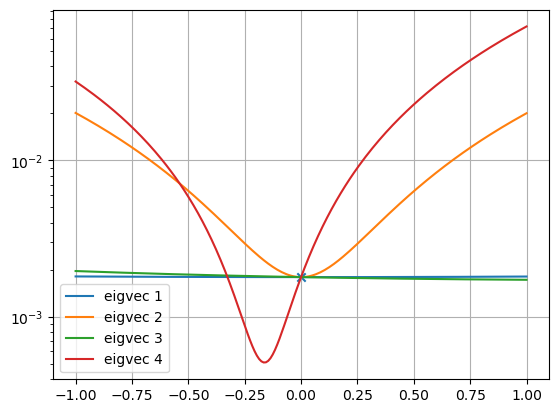

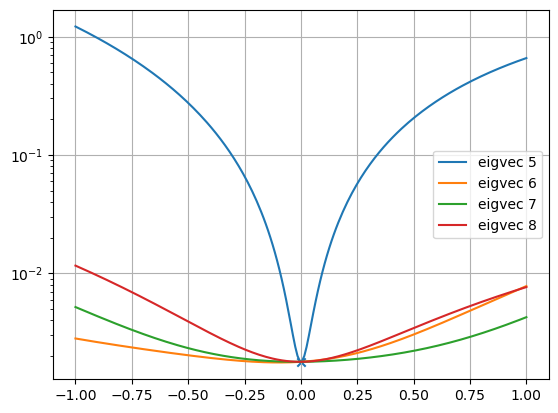

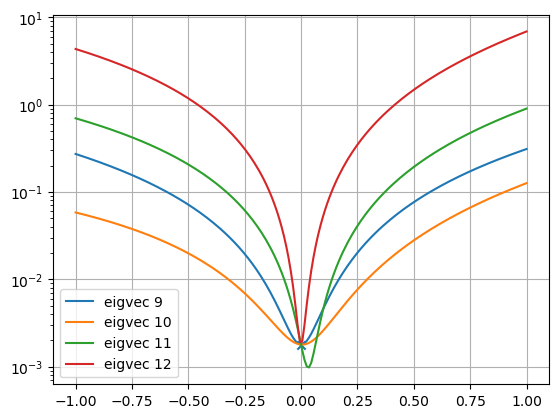

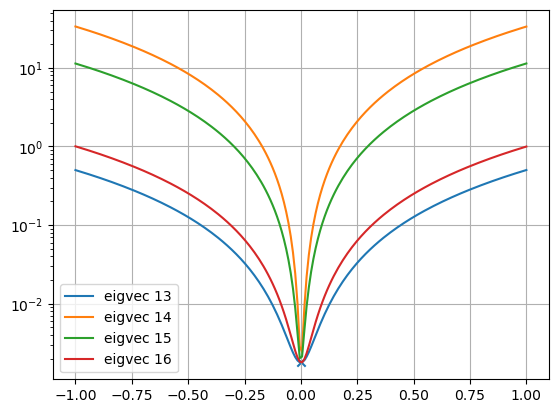

In [439]:
#plt.plot(steps, [Circuit_3954_L2_sc(*p) for p in  test_points])
steps = np.linspace(-1, 1, 200)

for i,direction in enumerate(pca.components_):
    test_points = directional_linspace(original_params, direction, steps)
    plt.plot(steps, [Circuit_3954_L2_sc(*p) for p in  test_points], label=f"eigvec {i+1}")
    if (i+1)%4 == 0:
        original_L2 = Circuit_3954_L2_sc(*original_params)
        plt.scatter(0, original_L2, marker='x')
        plt.yscale('log');plt.legend();plt.grid();plt.show()


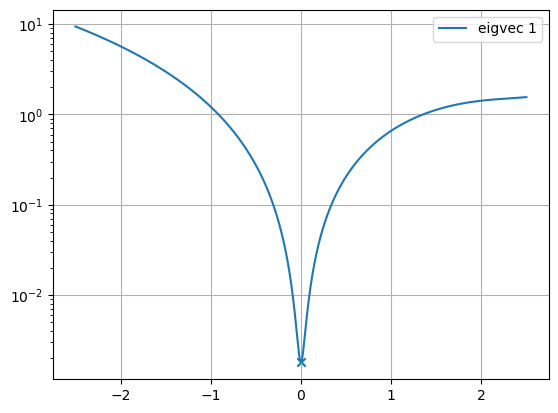

In [415]:
steps = np.linspace(-2.5, 2.5, 1000)
test_points = directional_linspace(original_params, pca.components_[4], steps)
plt.plot(steps, [Circuit_3954_L2_sc(*p) for p in  test_points], label=f"eigvec {1}")
original_L2 = Circuit_3954_L2_sc(*original_params)
plt.scatter(0, original_L2, marker='x')
plt.yscale('log');plt.legend();plt.grid();plt.show()

In [393]:
np.linspace(0, 5, 51)[::10]

array([0., 1., 2., 3., 4., 5.])

In [273]:
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from local_utils import *

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import *

In [279]:
model_128_10 = RD_2D_1st_Order(Ds=[params["D_A"], params["D_B"], 0], delta_t=100/5000, Lx=10, Ly=10, 
                            Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D
                       #boundary_condition=Periodic_Boundary_2D
                       # boundary_condition=Diritchlet_Boundary_2D
                       )

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [419]:
steps = np.linspace(0, 20, 201)[::50]
steps

array([ 0.,  5., 10., 15., 20.])

In [420]:

test_points = directional_linspace(original_params, pca.components_[3], steps)

In [421]:
test_points.shape

(5, 16)

1
A diff: 0.015436907805404633
B diff: 0.0007550427848266594
C diff: 8.976698020887337e-06
Sum: 0.01620092728825218

b_A:0.001, mu_A:0.1, V_A:5.0, K_AA:5.0, K_AB:5.0, K_AC:5.0,
b_B:1.0, mu_B:0.5, V_B:10.0, K_BA:5.0, K_BC:5.0,
b_C:20.0, mu_C:10.0, V_C:100.0, K_CB:10.0, K_CC:5.0


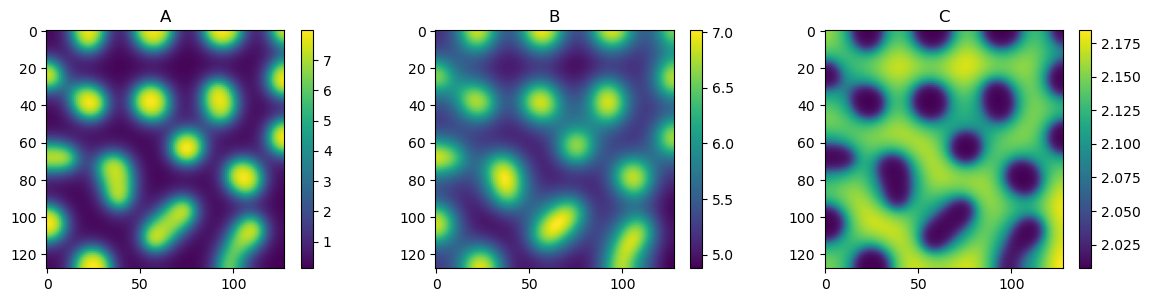

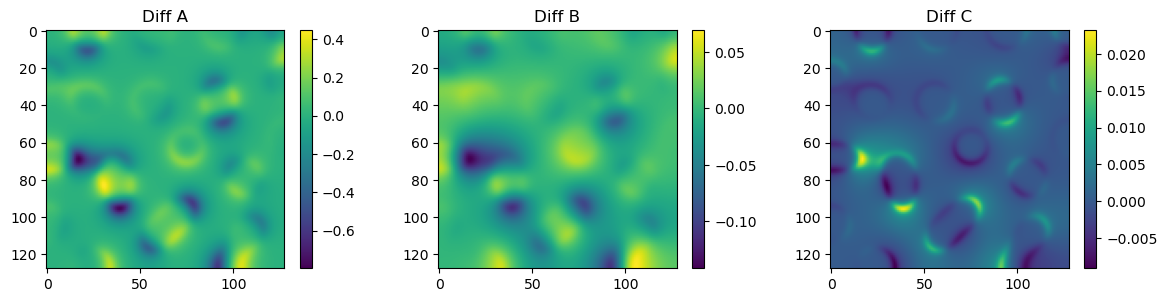

2
A diff: 4.055379510445355
B diff: 0.6827595311209254
C diff: 0.003264573998251557
Sum: 4.741403615564531

b_A:0.00100006063261747, mu_A:0.09977620859359923, V_A:4.986544816076918, K_AA:4.995179865869484, K_AB:4.367832241548609, K_AC:5.00525841821706,
b_B:1.004499684793613, mu_B:0.4848421682451605, V_B:5.040275733051156, K_BA:4.9927090731866866, K_BC:5.0005781658652975,
b_C:19.992974408153064, mu_C:9.996073023159076, V_C:99.99948135253524, K_CB:10.028413290265915, K_CC:4.99044587848487


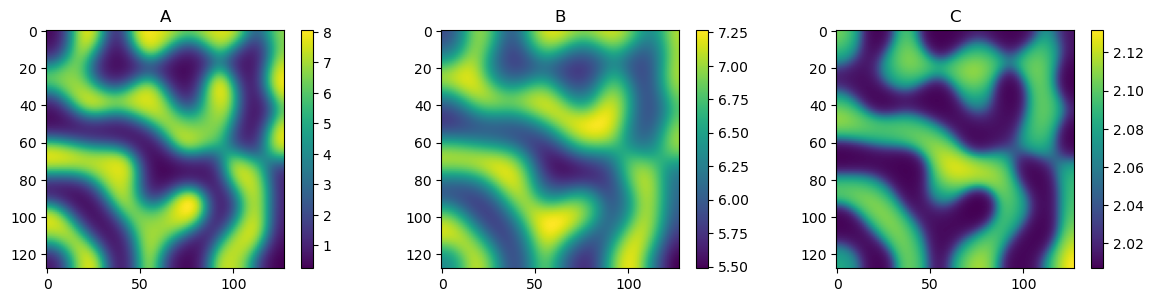

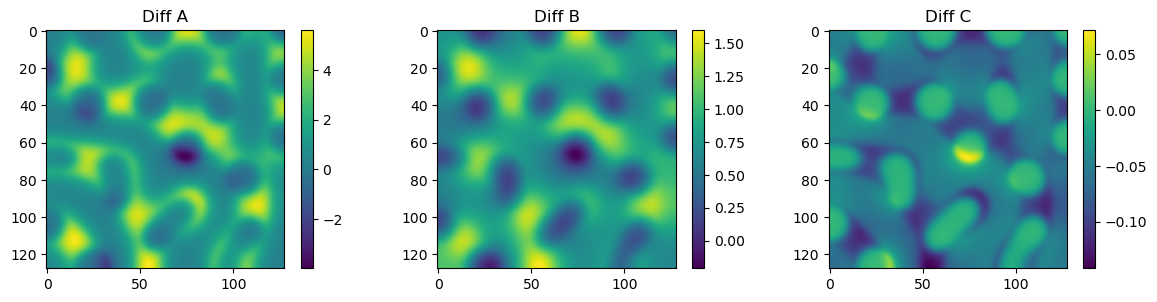

3
A diff: 2041.3594799877255
B diff: 11.816936803867105
C diff: 0.012860327710417275
Sum: 2053.189277119303

b_A:0.00100012126523494, mu_A:0.09955241718719846, V_A:4.973089632153837, K_AA:4.990359731738968, K_AB:3.7356644830972168, K_AC:5.010516836434119,
b_B:1.0089993695872261, mu_B:0.46968433649032104, V_B:0.08055146610231212, K_BA:4.985418146373373, K_BC:5.001156331730595,
b_C:19.985948816306124, mu_C:9.992146046318151, V_C:99.99896270507047, K_CB:10.056826580531832, K_CC:4.980891756969739


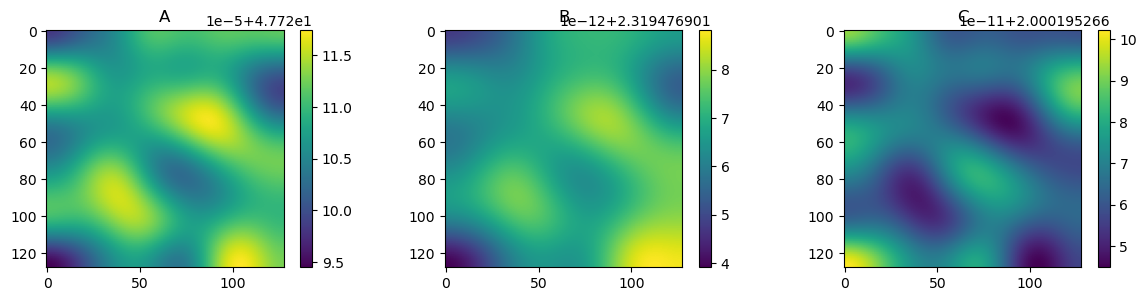

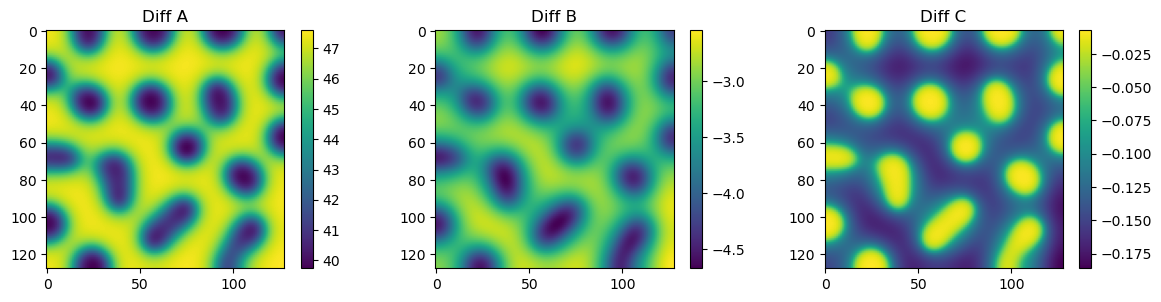

4
A diff: 10.034597385317443
B diff: 161.42967700643845
C diff: 0.007426394200041868
Sum: 171.47170078595596

b_A:0.00100018189785241, mu_A:0.09932862578079768, V_A:4.959634448230754, K_AA:4.985539597608451, K_AB:3.1034967246458254, K_AC:5.015775254651179,
b_B:1.013499054380839, mu_B:0.45452650473548156, V_B:-4.879172800846533, K_BA:4.97812721956006, K_BC:5.001734497595892,
b_C:19.978923224459187, mu_C:9.988219069477228, V_C:99.99844405760571, K_CB:10.085239870797746, K_CC:4.971337635454609


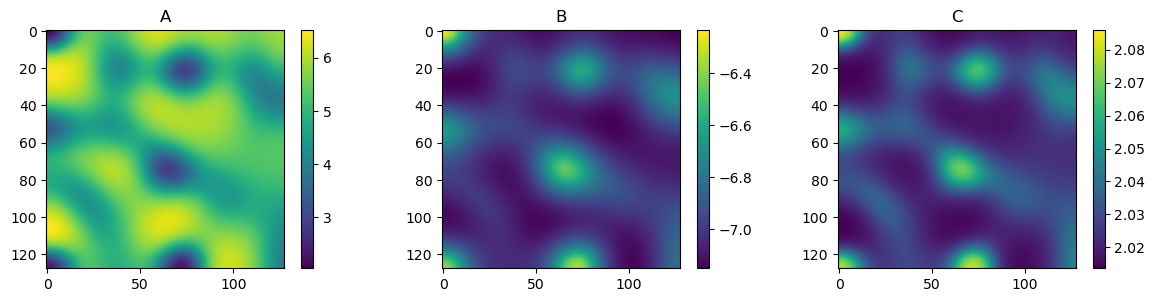

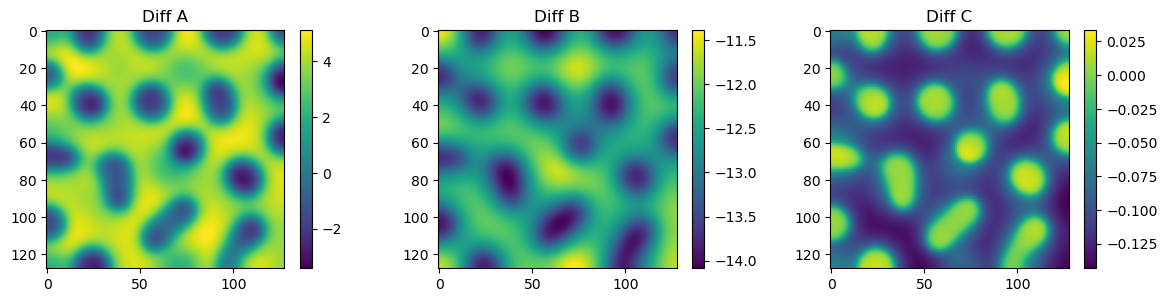

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_28935/3945920442.py", line 10, in <module>
    res2 = model_128_10.integrate([res[0, 0, :],res[0, 1, :],res[0, 2, :]],kinetics,5000)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/end/home/rh2310/morpho_repo/turing_codebase/pde_solvers/cn.py", line 442, in integrate
    return integrate_1st_order(N, self.Δt, Us_ret, self.A_facts, self.Bcsrs, Us, kinetics, self.BC2s, record_steps)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/end/home/rh2310/morpho_repo/turing_codebase/pde_solvers/cn.py", line 27, in integrate_1st_order
    Us = [
         ^
  File "/end/home/rh2310/morpho_repo/turing_codebase/pde_solvers/cn.py", line 

In [422]:
sols = []
for i,test_point in enumerate(test_points):
    (b_A, mu_A, V_A, K_AA, K_AB, K_AC,
     b_B, mu_B, V_B, K_BA, K_BC,
     b_C, mu_C, V_C, K_CB, K_CC) = test_point
    kinetics = create_circuit_3954(params["n"], 
                                   b_A, mu_A, V_A, K_AA, K_AB, K_AC,
                                   b_B, mu_B, V_B, K_BA, K_BC,
                                   b_C, mu_C, V_C, K_CB, K_CC)
    res2 = model_128_10.integrate([res[0, 0, :],res[0, 1, :],res[0, 2, :]],kinetics,5000)
    
    print("==============================================")
    print(i+1)
    print(f"A diff: {np.mean((res2[-1, 0, :]-res[-1, 0, :])**2)}")
    print(f"B diff: {np.mean((res2[-1, 1, :]-res[-1, 1, :])**2)}")
    print(f"C diff: {np.mean((res2[-1, 2, :]-res[-1, 2, :])**2)}")
    print(f"Sum: {np.mean((res2[-1, 0, :]-res[-1, 0, :])**2)+np.mean((res2[-1, 1, :]-res[-1, 1, :])**2)+np.mean((res2[-1, 2, :]-res[-1, 2, :])**2)}")
    print()
    print(f"b_A:{b_A}, mu_A:{mu_A}, V_A:{V_A}, K_AA:{K_AA}, K_AB:{K_AB}, K_AC:{K_AC},\n"
          f"b_B:{b_B}, mu_B:{mu_B}, V_B:{V_B}, K_BA:{K_BA}, K_BC:{K_BC},\n"
          f"b_C:{b_C}, mu_C:{mu_C}, V_C:{V_C}, K_CB:{K_CB}, K_CC:{K_CC}")
    plot_n_im([to(res2[-1, 0, :]), to(res2[-1, 1, :]), to(res2[-1, 2, :])], 
              ["A", "B", "C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()
    
    plot_n_im([to(res2[-1, 0, :]-res[-1, 0, :]), 
               to(res2[-1, 1, :]-res[-1, 1, :]), 
               to(res2[-1, 2, :]-res[-1, 2, :])], 
              ["Diff A", "Diff B", "Diff C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

In [ ]:
'b_A': 0.001, 'mu_A': 0.1, 'V_A': 5.0, 'K_AA': 5.0, 'K_AB': 5.0, 
'K_AC': 5.0, 
'b_B': 1.0, 'mu_B': 0.5, 'V_B': 10.0, 'K_BA': 5.0, 'K_BC': 5.0,
'b_C': 20.0, 'mu_C': 10.0, 'V_C': 100.0, 'K_CB': 10.0, 'K_CC': 5.0

In [433]:
pca.components_[14]

array([-1.35359564e-05,  9.99999806e-01, -2.55186000e-04,  2.07604807e-04,
        4.21194681e-05,  7.87856805e-05, -7.24835857e-05, -6.45025098e-05,
       -4.92957091e-05, -4.99582032e-04,  4.22273296e-05,  8.33870502e-06,
       -1.27828367e-05,  2.03545064e-06, -1.41013559e-05,  8.69423611e-05])

In [275]:
test_points.shape

(10, 16)

In [280]:
res2.shape

(10000, 3, 16384)